/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05633D+00    |proj g|=  5.53678D-02

At iterate    5    f=  1.03941D+00    |proj g|=  4.01725D-02

At iterate   10    f=  1.02529D+00    |proj g|=  1.69634D-02

At iterate   15    f=  1.02325D+00    |proj g|=  3.36415D-03

At iterate   20    f=  1.02279D+00    |proj g|=  3.08054D-03

At iterate   25    f=  1.02260D+00    |proj g|=  2.16651D-03

At iterate   30    f=  1.02222D+00    |proj g|=  2.40760D-03

At iterate   35    f=  1.02167D+00    |proj g|=  3.12541D-03

At iterate   40    f=  1.02144D+00    |proj g|=  2.45898D-03

At iterate   45    f=  1.02119D+00    |proj g|=  3.02875D-03


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.02108D+00    |proj g|=  1.43398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     55      1     0     0   1.434D-03   1.021D+00
  F =   1.0210813974811603     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Model Performance for Next 144 Blocks:
MAE: 1.6330
RMSE: 1.9176
R²: -0.6127
MAPE: nan%
Directional Accuracy: 9.7902%


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_10791/1414703789.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10), periods=steps, freq='10T'))
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_10791/1414703789.py:68: RuntimeWarning: '<' not supported between instances o

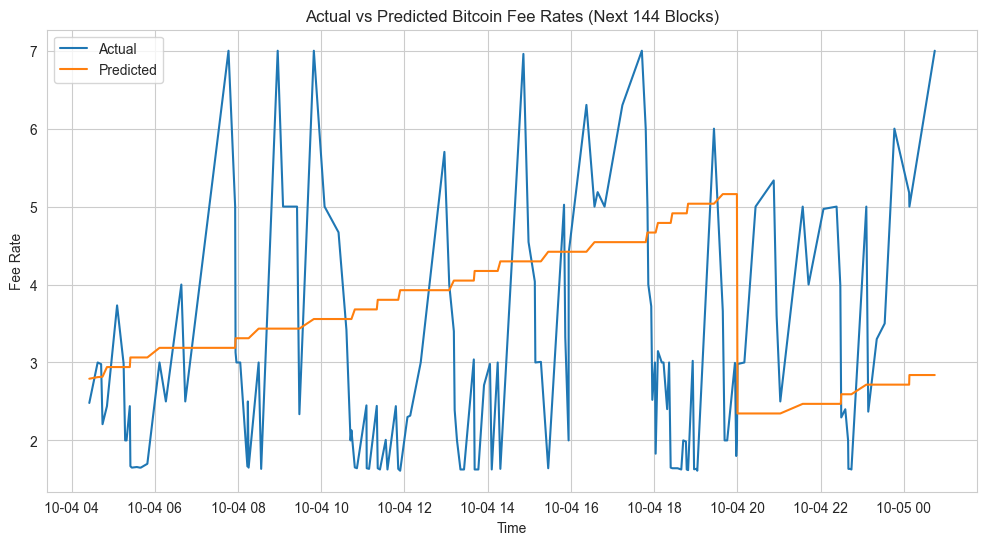

                                 SARIMAX Results                                 
Dep. Variable:     block_median_fee_rate   No. Observations:                 2488
Model:                  SARIMAX(1, 1, 1)   Log Likelihood               -2540.451
Date:                   Sat, 05 Oct 2024   AIC                           5122.901
Time:                           21:36:14   BIC                           5245.097
Sample:                                0   HQIC                          5167.276
                                  - 2488                                         
Covariance Type:                     opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
tx_count                1.1476      0.156      7.350      0.000       0.842       1.454
mempool_size_mb         2.6211      0.342      7.654      0.000       1.950     

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])


df['hour'] = df['block_time'].dt.hour
df['day_of_week'] = df['block_time'].dt.dayofweek

df = df.sort_values('block_time').set_index('block_time')

features = [
    'tx_count', 'mempool_size_mb', 'avg_fee_rate',
    'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
    'block_interval', 'bitcoin_price_usd',
    'hist_low_fee_ratio', 'hist_med_fee_ratio', 'hist_high_fee_ratio',
    'hist_fee_diversity', 'hour', 'day_of_week'
]
target = 'block_median_fee_rate'


X = df[features]
y = df[target]

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)

# Use RobustScaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.fillna(X.median())), columns=X.columns, index=X.index)

# Split data into train and test (last 144 blocks for test)
train_X = X_scaled[:-144]
train_y = y[:-144]
test_y = y[-144:]

# Fit SARIMAX model
model = SARIMAX(train_y, exog=train_X, order=(1,1,1))
results = model.fit()

# Function to generate simple forecasts for exogenous variables
def forecast_exog(X, steps):
    forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10), periods=steps, freq='10T'))
    for col in X.columns:
        if col in ['hour', 'day_of_week']:
            forecast[col] = forecast.index.hour if col == 'hour' else forecast.index.dayofweek
        else:
            # Use the last value for other variables
            forecast[col] = X[col].iloc[-1]
    return forecast

# Generate forecasts for exogenous variables
future_exog = forecast_exog(train_X, 144)

# Predict next 144 blocks
predictions = results.forecast(steps=144, exog=future_exog)

# Evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
r2 = r2_score(test_y, predictions)
mape = mean_absolute_percentage_error(test_y, predictions)
da = directional_accuracy(test_y, predictions)

print("Model Performance for Next 144 Blocks:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y.values, label='Actual')
plt.plot(test_y.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 144 Blocks)')
plt.xlabel('Time')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()


print(results.summary())